# Model evaluation

In [1]:
import sys
sys.path.append('../')
from fastai.vision.all import *
from mocatml.data import *
from mocatml.utils import *
from mocatml.models.utils import *
from tsai.imports import my_setup
from tsai.utils import yaml2dict, dict2attrdict
from mygrad import sliding_window_view
import wandb

In [2]:
my_setup()

os              : Linux-6.2.0-37-generic-x86_64-with-glibc2.31
python          : 3.9.17
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.1+cu121
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.3 GB
GPU memory      : N/A


In [3]:
config = yaml2dict('./config/convgru/eval.yaml')
config

```json
{ 'data': { 'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy',
            'split_idx': 1},
  'device': 'cpu',
  'horizon': 4,
  'learner': { 'fname': 'learner.pkl',
               'path': 'tmp',
               'wandb': { 'dir': '~/Github/mocat-ml',
                          'download_path': 'wandb/artifacts/density-forecaster',
                          'enabled': False}},
  'lookback': 4,
  'mmap': True,
  'norm': {'mean': None, 'std': None},
  'sel_steps': 100,
  'stride': 2}
```

In [4]:
# Set device
default_device(0 if config.device == 'cpu' else config.device)

device(type='cpu')

In [5]:
wandb_api = wandb.Api()
if config.learner.wandb.enabled:
    ar = wandb_api.artifact(config.learner.path)
    lp = ar.download(root= Path(config.learner.wandb.dir).expanduser()/\
                            Path(config.learner.wandb.download_path))
    lp = lp/Path(config.learner.fname)
else:
    lp = Path(config.learner.path)/Path(config.learner.fname)
learn = load_learner(lp, cpu=default_device() == torch.device("cpu"))
learn

wandb: WARNING Path /workspaces/mocat-ml /wandb/ wasn't writable, using system temp directory


In [6]:
if config.learner.wandb.enabled:
    run = ar.logged_by()
    config.lookback = run.config['lookback']
    config.horizon = run.config['horizon']
    config.sel_steps = run.config['sel_steps']
    config.stride = run.config['stride']
print(f'lookback: {config.lookback}, horizon: {config.horizon}, sel_steps: {config.sel_steps}, stride: {config.stride}')

lookback: 4, horizon: 4, sel_steps: 100, stride: 2


In [7]:
X = np.load(Path(config.data.path).expanduser(), 
               mmap_mode='c' if config.mmap else None)
if config.data.split_idx is not None:
    X = X[learn.splits[config.data.split_idx], :config.sel_steps]
X.shape

(20, 100, 36, 99)

In [8]:
X_sw = np.lib.stride_tricks.sliding_window_view(X, 
                                               config.lookback + config.horizon, 
                                               axis=1)[:,::config.stride,:]
samples_per_simulation = X_sw.shape[1]
X_sw = X_sw.transpose(0,1,4,2,3)
X_sw = X_sw.reshape(-1, *X_sw.shape[2:])
X_sw.shape

(940, 8, 36, 99)

In [9]:
train_stats = (learn.dls.train.after_batch.mean, learn.dls.train.after_batch.std)
ds = DensityData(X_sw, lbk=config.lookback, h=config.horizon)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
dl = TfmdDL(tl, bs=learn.dls.valid.bs, shuffle=False, num_workers=0, 
            after_batch=Normalize.from_stats(*train_stats))
xb,yb = dl.one_batch()
len(xb), xb[0].shape, len(yb), yb[0].shape

(4, torch.Size([32, 1, 36, 99]), 4, torch.Size([32, 1, 36, 99]))

In [10]:
p, t = learn.get_preds(dl=dl)
valid_loss = learn.loss_func(p, t)
print(f'valid_loss: {valid_loss}')

valid_loss: TensorBase(36.4463)


In [11]:
losses = learn.get_individual_losses(p, t)
losses.shape

torch.Size([940])

In [12]:
interp = Interpretation(learn, dl, losses)
_, best_idx = interp.top_losses(k=1, largest=False)
_, worst_idx = interp.top_losses(k=1, largest=True)
best_idx, worst_idx

(tensor([1]), tensor([751]))

In [38]:
inps, preds, targs = learn.get_preds(dl=dl, with_input=True)

In [50]:
import importlib
import mocatml
importlib.reload(mocatml.models.utils)
importlib.reload(mocatml.data)

<module 'mocatml.data' from '/workspaces/mocat-ml/nbs/../mocatml/data.py'>

In [ ]:
inps_seq = DensitySeq.create(inps[i][worst_idx] for i in range(len(inps)))


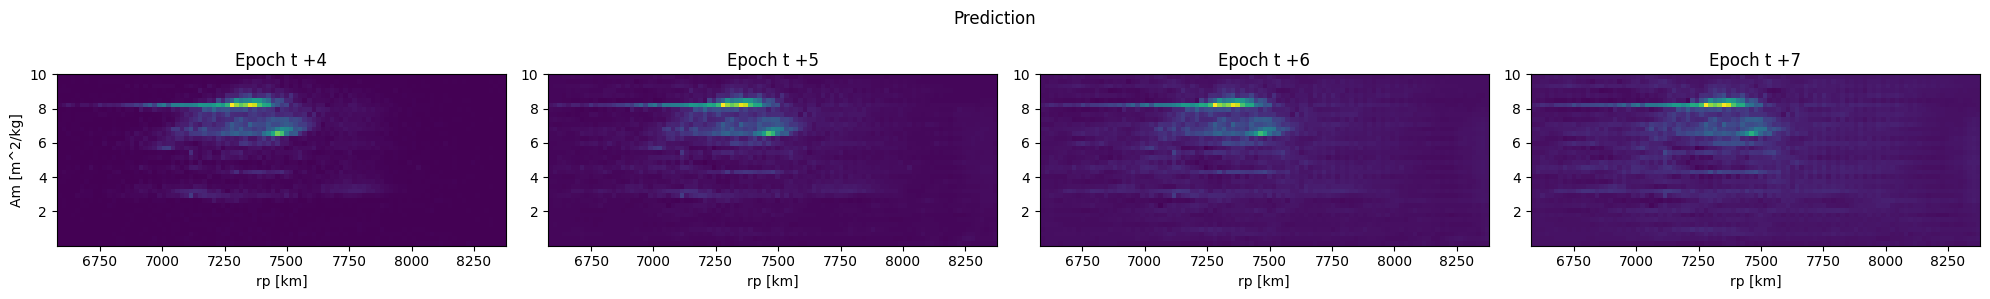

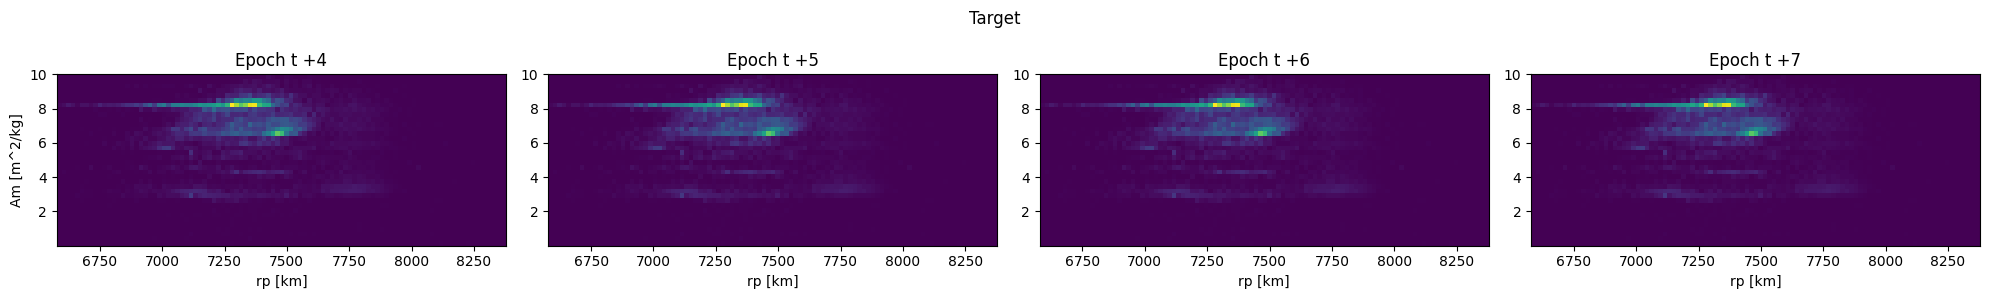

In [51]:
learn.show_preds_at(worst_idx, p=preds, t=targs)